# Lunar Lander Environment with pytorch

 Information regarding environment: https://gym.openai.com/envs/LunarLander-v2/


Variables associated with the state space: 
- x coordinate of the lander
- y coordinate of the lander
- vx, the horizontal velocity
- vy, the vertical velocity
- θ, the orientation in space
- vθ, the angular velocity
- Left leg touching the ground (Boolean)
- Right leg touching the ground (Boolean)


## Importing libraries

In [ ]:
# Installations for rendering
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
# General packages
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from statistics import mean

# Rendering
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# Torch related
import torch
import torch.nn as nn
import torch.nn.functional as F

## Build neural network

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_dims, n_actions):
    """
    input_dims = input shape (number of features)
    n_actions = number of neurons in output layer
    """
    super(NeuralNet, self).__init__() # Importing all attributes from parent

    self.layer1 = nn.Linear(input_dims, 32) # Simple linear network
    self.layer2 = nn.Linear(32, 16)
    self.layer3 = nn.Linear(16, n_actions)
    self.activation = nn.ReLU()

  def forward(self, x):
    """
    To pass the results forward in the neural net
    Args:
      x: input data
    """
    l1 = self.layer1(x)
    l1_ =self.activation(l1)
    l2 = self.layer2(l1_)
    l2_ = self.activation(l2)
    l3 = self.layer3(l2_)
    return l3


## Replay memory

In [ ]:
class ReplayBuffer():
  def __init__(self, mem_size, batch_size,input_dims):
    """
    Initialization of replay buffer, creating different numpy arrays for each component
    Input dims can be n-dimensional value
    """
    self.mem_size = mem_size
    self.batch_size = batch_size
    self.mem_counter = 0 # memory counter
    self.state_mem = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
    self.action_mem = np.zeros(self.mem_size, dtype=np.float32)
    self.reward_mem = np.zeros(self.mem_size, dtype=np.float32)
    self.next_state_mem = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
    self.terminal_mem = np.zeros(self.mem_size, dtype=np.float32) # done represents zero

  def store_record(self, state, action, reward, state_, done):
    """
    Stores the current values on the memory
    """
    index = self.mem_counter % self.mem_size # once is full, it restores it
    self.state_mem[index] = state
    self.action_mem[index] = action
    self.reward_mem[index] = reward
    self.next_state_mem[index] = state_ # can also be named "next_state"
    self.terminal_mem[index] = 1 - int(done) # change boolean to 1-0
    self.mem_counter = self.mem_counter + 1
  def is_sampleable(self):
    """
    Tells if can be sampled
    """
    if(self.mem_counter >= self.batch_size):
      return True
    else:
      return False


  def sample_buffer(self):
    """
    Samples from buffer, do not sample any zeros
    Output tuple with the sample
    """
    if not(self.is_sampleable()):
      return []

    max_mem = min(self.mem_size, self.mem_counter) # make sure it does not sample zeros

    
    batch = np.random.choice(max_mem,
                             self.batch_size, 
                             replace=False) # sampling, with no replace

    states = self.state_mem[batch]
    actions = self.action_mem[batch]
    rewards = self.reward_mem[batch]
    next_states = self.next_state_mem[batch]
    terminals = self.terminal_mem[batch]

    return states, actions, rewards, next_states, terminals



## Agent - DQN

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class dqn_agent():
  def __init__(self, 
               input_dims, 
               n_actions,
               epsilon_decay=(1-(1e-4)), # Number close to 1
               gamma=0.99, 
               lr=1e-4, 
               mem_size=1024, 
               batch_size=64):
    """
    DQN Agent
    Args: 
      epsilon_decay: factor which is going to decay toward zero
      gamma : discounted factor in Bellman equation 
      lr : learning rate
      mem_size : memory size 
      batch_size : batch size, should be a power of 2
    """
    self.input_dims = input_dims[0]
    self.n_actions = n_actions

    self.epsilon_decay = epsilon_decay
    self.epsilon = 1

    self.gamma = gamma
    self.lr = lr

    self.mem_size = mem_size
    self.batch_size = batch_size

    self.replay_mem = ReplayBuffer(mem_size = mem_size, 
                                   batch_size = batch_size, 
                                   input_dims = input_dims)
    
    self.policy_network = NeuralNet( input_dims = self.input_dims,
                                  n_actions = n_actions).to(device)
    self.loss_function = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.policy_network.parameters(),
                                      lr = lr)



            
    
  def choose_action(self, obs):
    """
    Agent to choose an action at any state
    Arg: 
      obs: Is the state (features) 

    Returns: 
      action to take
    """
    if(np.random.random() > self.epsilon):
      obs_T = torch.tensor(obs, device = device).float()
      with torch.no_grad(): # no_grad is to calculate the action first, means no gradient
        q_values = self.policy_network(obs_T).cpu().detach().numpy() # only getting the q values 
        action = np.argmax(q_values)
        # No replay memory because that is for training
    else: # we want it to explore
      action = np.random.randint(self.n_actions)
    
    return action

  def store_mem(self, state, action, reward, state_, done):
    """
    Stores in the memory 
    """
    self.replay_mem.store_record(state, action, reward, state_, done)

  def train(self):
    """
    Training with replay memory 
    """
    if not(self.replay_mem.is_sampleable()):
      return np.nan # if not sampleable, don't train and return nan loss
    
    states, actions, rewards, next_states, dones = self.replay_mem.sample_buffer()

    states_T = torch.tensor(states, device = device).float()
    actions_T = torch.tensor(actions, device = device).type(torch.int64).unsqueeze(1) # unsqueeze converts into higher dimension, this we only use it as a key
    rewards_T = torch.tensor(rewards, device = device).float()
    next_states_T = torch.tensor(next_states, device = device).float()
    dones_T = torch.tensor(dones, device = device).type(torch.int64)

    q_values = self.policy_network(states_T).gather(1, actions_T).squeeze(1) # gathering q values from the network for that action

    with torch.no_grad():
      q_values_next = self.policy_network(next_states_T).max(1)[0].detach() # max q value

    q_target_values = rewards_T + self.gamma * q_values_next * dones

    loss = self.loss_function(q_values, q_target_values)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.epsilon = self.epsilon * self.epsilon_decay

    return loss.item() # loss.item is just the value



    




Parameters

In [ ]:

lr = 1e-4
gamma = 0.99
epsilon_decay = 1- (3e-5)

episodes = 700

mem_size = 10000
batch_size = 64


## Environment

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

     |████████████████████████████████| 448 kB 7.4 MB/s 


## Training

In [ ]:
agent = dqn_agent(input_dims=env.observation_space.shape, 
                  n_actions=env.action_space.n, 
                  epsilon_decay=epsilon_decay, 
                  gamma = gamma,
                  lr = lr,
                  mem_size = mem_size, 
                  batch_size = batch_size
                  )

In [ ]:
scores = []
eps = []
losses = []

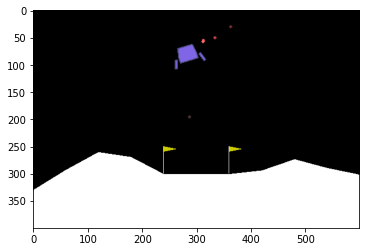

In [ ]:
pbar = tqdm(range(episodes))

for i in pbar: 
  done = False
  score = 0
  state = env.reset()
  ep_loss = []
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)

  while not(done):
    # Agent chooses action
    action = agent.choose_action(state)
    
    # Environment's new state, reward and others
    new_state, reward, done, _ = env.step(action) #"_" is info to debug

    # Rendering
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())


    score = score + reward

    # Store record in memory
    agent.store_mem(state, action, reward, new_state, done)

    # Copy of state
    state = deepcopy(new_state)

    # Keep track of loss
    loss = agent.train()
    ep_loss.append(loss) # episode loss
  
  # At the end of episode, do the following: 
  scores.append(score)
  eps.append(agent.epsilon)
  losses.append(mean(ep_loss))
  pbar.set_description("current score = %s" % score)

ipythondisplay.clear_output(wait=True)
env.close()


## Agent - DDQN